In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.signal import periodogram
from scipy.fft import fft

import warnings
warnings.filterwarnings("ignore")


In [22]:
data = pd.read_csv("data/cern.us.txt", sep=",", parse_dates=True, index_col=0)

In [23]:
data.tail()

,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2017-11-06,65.36,65.810,65.06,65.71,1359851,0
2017-11-07,65.78,66.240,65.67,65.93,1404928,0
2017-11-08,65.85,66.470,65.60,66.28,1331746,0
2017-11-09,65.87,66.105,64.69,65.48,1491859,0
2017-11-10,65.31,65.560,64.93,65.31,1327855,0


In [24]:
data.reset_index(inplace=True)
data.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
3196,2017-11-06,65.36,65.810,65.06,65.71,1359851,0
3197,2017-11-07,65.78,66.240,65.67,65.93,1404928,0
3198,2017-11-08,65.85,66.470,65.60,66.28,1331746,0
3199,2017-11-09,65.87,66.105,64.69,65.48,1491859,0
3200,2017-11-10,65.31,65.560,64.93,65.31,1327855,0


In [25]:
# above code is for the data of CERN.US, reset the index and tail of the data


In [26]:
df = data[data["Date"].dt.year >= 2010].copy() \
    .sort_values(by="Date") \
    .reset_index(drop=True)

df.tail()



,Date,Open,High,Low,Close,Volume,OpenInt
1974,2017-11-06,65.36,65.810,65.06,65.71,1359851,0
1975,2017-11-07,65.78,66.240,65.67,65.93,1404928,0
1976,2017-11-08,65.85,66.470,65.60,66.28,1331746,0
1977,2017-11-09,65.87,66.105,64.69,65.48,1491859,0
1978,2017-11-10,65.31,65.560,64.93,65.31,1327855,0


In [27]:
fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
fig.add_trace(go.Ohlc(x=df["Date"],
                       open=df["Open"],
                       high=df["High"],
                       low=df["Low"],
                       close=df["Close"],
                       name="Price"),
row=1, col=1)
fig.add_trace(go.Scatter(x=df["Date"],
                         y=df["Volume"],
                         name="Volume"),

row=2, col=1)
fig.update_layout(title="CERN.US",
                                width=1000,
              height=800,
                   xaxis_rangeslider_visible=True)
fig.show()


In [28]:
frequencies, spectrum = periodogram(df["Close"])
top_k = 10
dominant_frequencies = frequencies[spectrum.argsort()[::-1][:top_k]]
seasonal_periods = 1 / dominant_frequencies
print(f"Potential seasonal periods: list{seasonal_periods}")


Potential seasonal periods: list[1979.          494.75        659.66666667  989.5         329.83333333
  282.71428571  219.88888889  247.375       395.8         152.23076923]


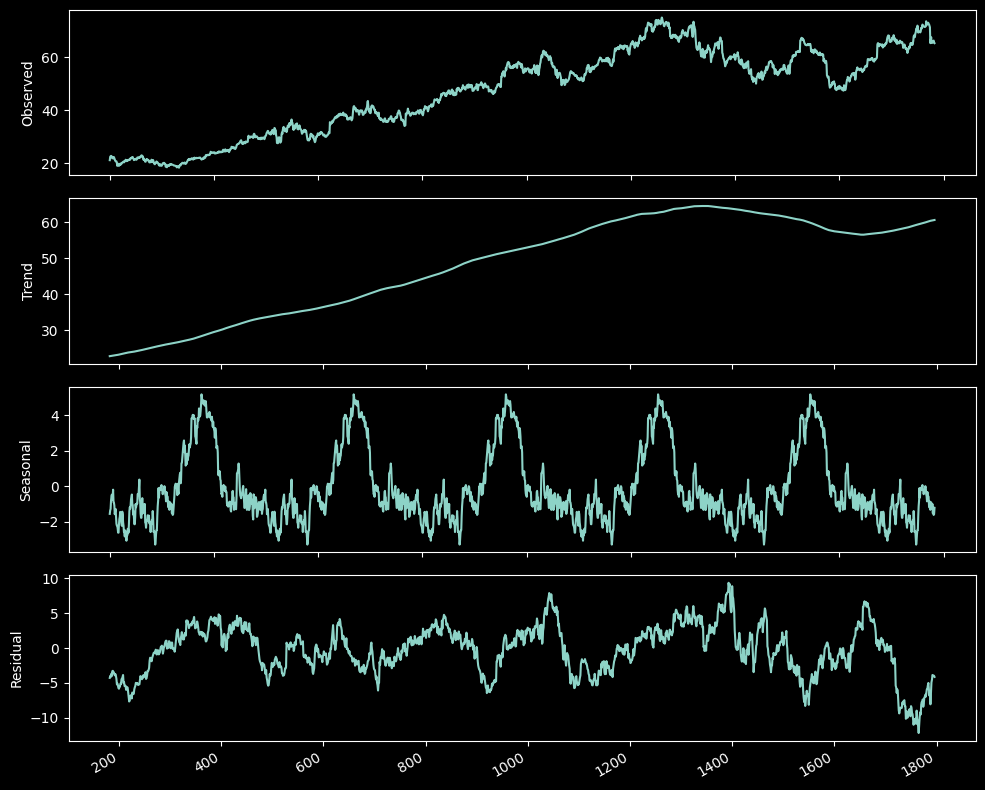

In [29]:
def decompose_ts(df, model="additive", period=12):
    decomposition = seasonal_decompose(df["Close"], model=model, period=period)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
    ax1.plot(decomposition.observed)
    ax1.set_ylabel("Observed")
    ax2.plot(decomposition.trend)
    ax2.set_ylabel("Trend")
    ax3.plot(decomposition.seasonal)
    ax3.set_ylabel("Seasonal")
    ax4.plot(decomposition.resid)
    ax4.set_ylabel("Residual")
    
    fig.autofmt_xdate()
    plt.tight_layout()
    
decompose_ts(df, model="additive", period=365)


In [30]:
series = df["Close"]; series

0       21.068
1       22.313
2       22.548
3       22.680
4       22.633
         ...  
1974    65.710
1975    65.930
1976    66.280
1977    65.480
1978    65.310
Name: Close, Length: 1979, dtype: float64

In [31]:
result = seasonal_decompose(series, model="additive", period=365)

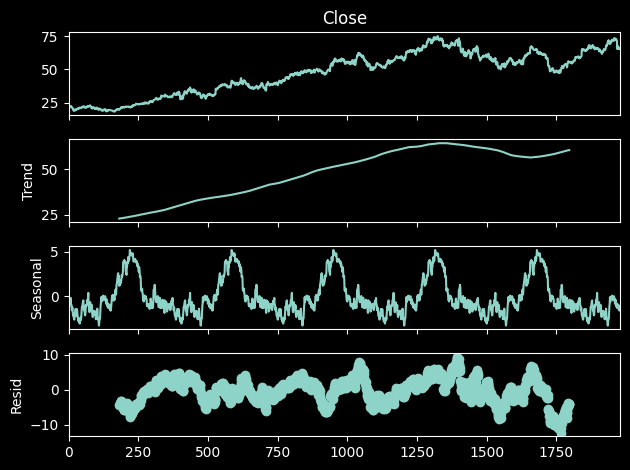

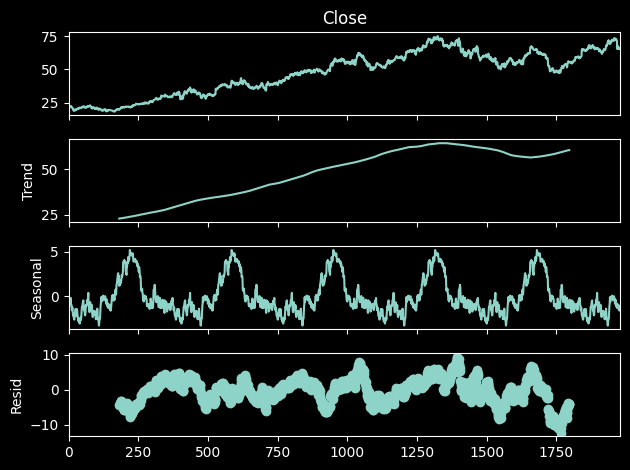

In [32]:
result.plot()


In [33]:
def check_stationarity(series, p_significant=0.05):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    adfuller_result = adfuller(series)
    kpss_result = kpss(series)

    print(f'ADF Statistic : {adfuller_result[0]:.5f}, p-value: {adfuller_result[1]:.5f}')
    print('Critical Values:')
    for key, value in adfuller_result[4].items():
        print('\t%s: %.3f' % (key, value))
    print(f'KPSS Statistic: {kpss_result[0]:.5f}, p-value: {kpss_result[1]:.5f}')
    if (adfuller_result[1] <= p_significant) & (adfuller_result[4]['5%'] > adfuller_result[0]) & (kpss_result[1] > p_significant):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [34]:
check_stationarity(df["Close"])


ADF Statistic : -1.38581, p-value: 0.58906
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
KPSS Statistic: 5.93488, p-value: 0.01000
Non-stationary


In [35]:
df_close_diff = np.diff(df["Close"], n= 1)
check_stationarity(df_close_diff)


ADF Statistic : -45.65103, p-value: 0.00000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
KPSS Statistic: 0.06586, p-value: 0.10000
Stationary


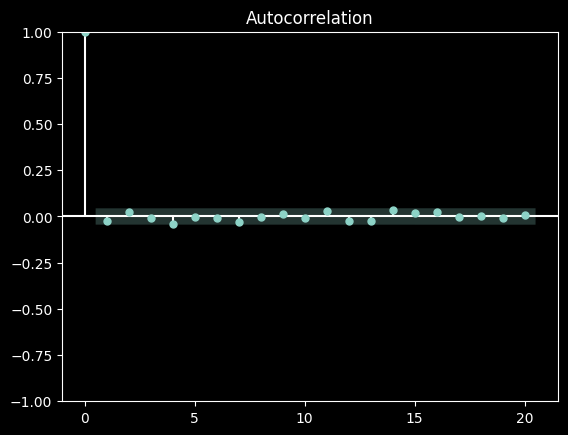

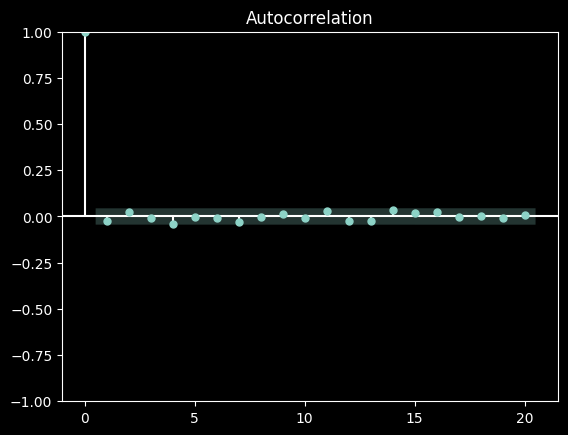

In [36]:
plot_acf(df_close_diff, lags=20)


In [37]:
df = df.drop(columns=["Volume", "Open", "High", "Low","OpenInt"])


In [38]:
df

,Date,Close
0,2010-01-04,21.068
1,2010-01-05,22.313
2,2010-01-06,22.548
3,2010-01-07,22.680
4,2010-01-08,22.633
...,...,...
1974,2017-11-06,65.710
1975,2017-11-07,65.930
1976,2017-11-08,66.280
1977,2017-11-09,65.480


### FEATURE ENGINEERING


In [39]:
class FePipeline:
    def __init__(self, 
                 target_column: str,
                 date_column: str,
                 lags: list[int],
                 windows: list[int],
                 rolling_stats: list[str], 
                 ):
        self.target_column = target_column
        self.date_column = date_column
        self.lags = lags
        self.windows = windows
        self.rolling_stats = rolling_stats
    def run_pipeline(self, df):
        ts = df.copy()
        ts = self._create_date_features(ts)
        ts = self._create_lag_feature(ts)
        ts = self._create_rolling_features(ts)
        ts = self._create_rate_of_change_feature(ts)
        ts = self._create_ema_features(ts)
        ts = self._create_macd_features(ts)
        ts = self._create_rsi_feature(ts, window=5)
        ts = self._create_fourier_transform(ts)
        return ts

    def _create_date_features(self, ts):
        if not pd.api.types.is_datetime64_any_dtype(ts[self.date_column]):
            df.loc[:, self.date_column] = pd.to_datetime(df[self.date_column])
        
        ts['day_of_week'] = ts[self.date_column].dt.dayofweek
        ts['is_weekend'] = (ts[self.date_column].dt.dayofweek >= 5).astype(int)
        ts['day'] = ts[self.date_column].dt.day
        ts['month'] = ts[self.date_column].dt.month
        ts['quarter'] = ts[self.date_column].dt.quarter
        ts['year'] = ts[self.date_column].dt.year
        ts['day_of_year'] = ts[self.date_column].dt.dayofyear
        #ts['week_of_year'] = ts[self.date_column].dt.weekofyear
        # sine-cosine features: capturing cyclical patterns such as daily, weekly, or yearly cycles.
        ts['sin_dayofweek'] = np.sin(2 * np.pi * ts[self.date_column].dt.dayofweek / 7)
        ts['cos_dayofweek'] = np.cos(2 * np.pi * ts[self.date_column].dt.dayofweek / 7)
        ts['ismonthstart'] = ts[self.date_column].dt.is_month_start.astype(int)
        ts['ismonthend'] = ts[self.date_column].dt.is_month_end.astype(int)
        ts['isquarterstart'] = ts[self.date_column].dt.is_quarter_start.astype(int)
        ts['isquarterend'] = ts[self.date_column].dt.is_quarter_end.astype(int)
        ts['isyearstart'] = ts[self.date_column].dt.is_year_start.astype(int)
        ts['isyearend'] = ts[self.date_column].dt.is_year_end.astype(int)
        ts['isleapyear'] = ts[self.date_column].dt.is_leap_year.astype(int)
        
        return ts
    def _create_lag_feature(self, ts):
        for lag in self.lags:
            ts[f"lag_{lag}"] = ts[self.target_column].shift(lag)
        return ts
    def _create_rolling_features(self, ts):
        for stat in self.rolling_stats:
            for window in self.windows:
                if stat == "mean":
                    ts[f"rolling_mean_{window}"] = ts[self.target_column].rolling(window=window).mean()
                if stat == "std":
                    ts[f"rolling_mean_{window}"] = ts[self.target_column].rolling(window=window).ts()
        return ts
    def _create_rate_of_change_feature(self, ts):
        for n in self.lags:
            ts[f"roc_period={n}"] = ts[self.target_column].pct_change(periods=n) # try 1 and 5
        return ts
    def _create_ema_features(self, ts):
        for window in self.windows:
            ts[f"ema_{window}"] = ts[self.target_column].ewm(span=window, adjust=False).mean()
        return ts
    def _create_macd_features(self, ts):
        EMA_12 = pd.Series(ts[self.target_column].ewm(span=12, min_periods=12).mean())
        EMA_26 = pd.Series(ts[self.target_column].ewm(span=26, min_periods=26).mean())
        ts['MACD'] = pd.Series(EMA_12 - EMA_26)
        ts['MACD_signal'] = pd.Series(ts.MACD.ewm(span=9, min_periods=9).mean())
        return ts
    def _create_rsi_feature(self, ts, window):
        # Calculate price changes
        delta = ts[self.target_column].diff()

        # Separate gains and losses
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

        # Calculate Relative Strength (RS)
        rs = gain / loss

        # Calculate RSI
        ts["rsi"] = 100 - (100 / (1 + rs))
        return ts
    def _create_fourier_transform(self, ts):
        values = ts[self.target_column].values
        fourier_transform = fft(values)
        ts['fourier_transform'] = np.abs(fourier_transform)
        return ts

In [40]:
fe_pipeline = FePipeline("Close", "Date", 
                         lags=[1,2,3,4,5],
                         windows=[5, 10, 15, 30],
                         rolling_stats=['mean']
)
fe_df = fe_pipeline.run_pipeline(df)

NameError: name 'fft' is not defined